In [ ]:
#Install Dependencies
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU') #Check GPUs    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import cv2 #OpenCV Library
import imghdr #To Check File Extension

In [4]:
data_dir = 'data2' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
#To Remove any dodgy Images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#Creates a data Pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir) 

Found 425 files belonging to 2 classes.


In [7]:
#To allow us to access the images as batch
data_iterator = data.as_numpy_iterator()

In [8]:
#Run this to get another Batch
batch = data_iterator.next()

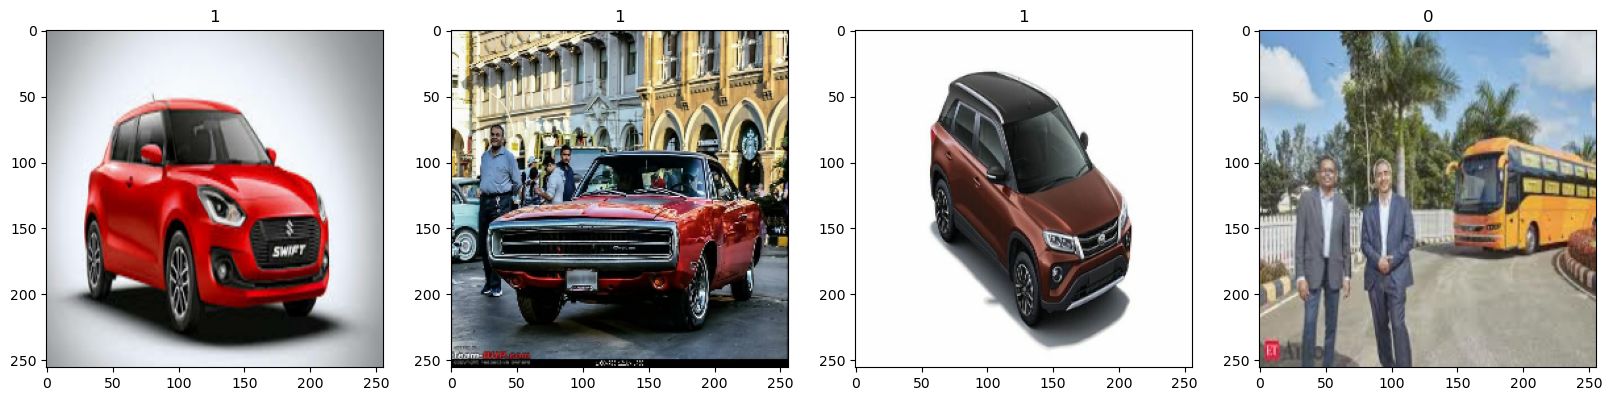

In [9]:
# Class 0= Bus; Class 1= Car
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
#Scale the Data
data = data.map(lambda x,y: (x/255, y))

In [12]:
#Split the data into Training,Validation and Testing sets
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
#Build the Deep Learning Model 
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [19]:
#Train the model
logdir='logs' #Store the logs in logs folder

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) 

In [21]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 23s 768ms/step - loss: 1.4072 - accuracy: 0.5312 - val_loss: 0.6916 - val_accuracy: 0.5156
Epoch 2/20
9/9 [==============================] - 11s 881ms/step - loss: 0.6905 - accuracy: 0.5521 - val_loss: 0.6761 - val_accuracy: 0.5625
Epoch 3/20
9/9 [==============================] - 11s 855ms/step - loss: 0.6634 - accuracy: 0.5972 - val_loss: 0.7003 - val_accuracy: 0.5000
Epoch 4/20
9/9 [==============================] - 11s 807ms/step - loss: 0.6503 - accuracy: 0.6597 - val_loss: 0.5941 - val_accuracy: 0.6562
Epoch 5/20
9/9 [==============================] - 10s 804ms/step - loss: 0.5495 - accuracy: 0.7569 - val_loss: 0.4740 - val_accuracy: 0.7969
Epoch 6/20
9/9 [==============================] - 11s 882ms/step - loss: 0.4453 - accuracy: 0.8194 - val_loss: 0.3738 - val_accuracy: 0.8438
Epoch 7/20
9/9 [==============================] - 11s 830ms/step - loss: 0.3545 - accuracy: 0.8785 - val_loss: 0.3322 - val_accuracy: 0.8750
Epoch 8/20
9/

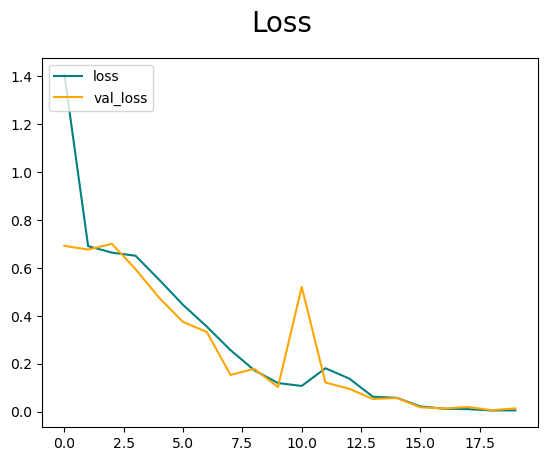

In [22]:
#Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

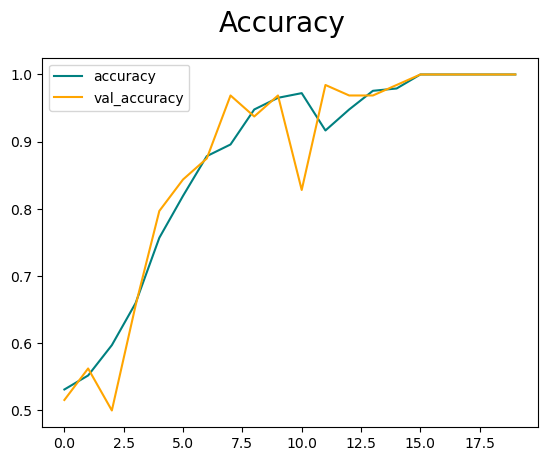

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
#Evaluate the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [25]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [26]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 289ms/step


In [27]:
print ('Precision: {}, Recall: {}, Accuracy: {}'.format(pre.result().numpy(), re.result().numpy(), acc.result().numpy()))

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


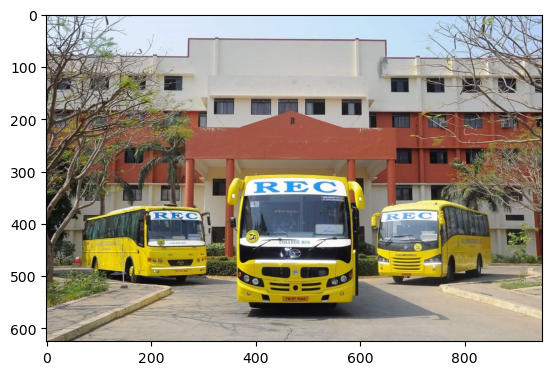

In [28]:
#Test the model

img = cv2.imread('1551372472phpGOyzEC.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

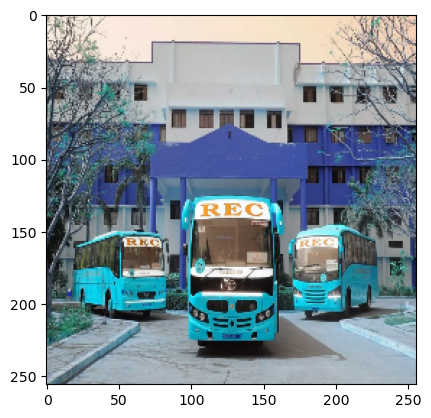

In [29]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [30]:
test_new = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 625ms/step


In [31]:
if test_new > 0.5: 
    print(f'Predicted class is Car')
else:
    print(f'Predicted class is Bus')

Predicted class is Bus


In [ ]:
#Save the model
model.save(os.path.join('models','buscarmodel.h5'))